In [1]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error

import math  
import numpy as np
import pandas as pd

# SIR model

In [2]:
# Total population, N without china
N = 6.4 *(10**9)
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.6, 1/10

In [3]:
# The SIR model differential equations.
def SIR(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


In [5]:
# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
# ret = odeint(deriv, y0, [i for i in range(1000)], args=(N, beta, gamma))
ret = odeint(SIR, y0, [i for i in range(1000)], args=(N, beta, gamma))

S, I, R = ret.T


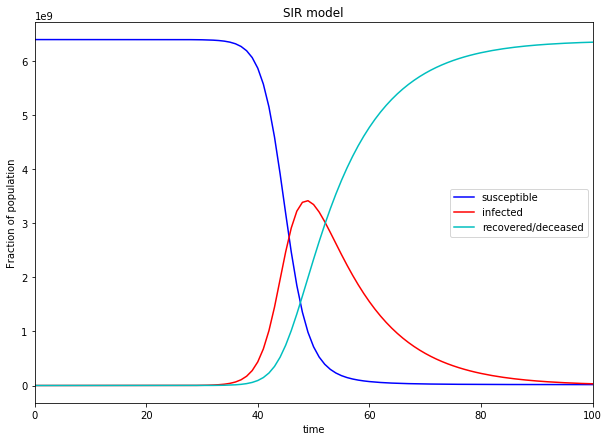

In [6]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b', label='susceptible');
plt.plot(I, 'r', label='infected');
plt.plot(R, 'c', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,100)
plt.show()

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,74,84,94,110,110,120,170,174,237,273
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,123,146,174,186,197,212,223,243,259,277
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,264,302,367,409,454,511,584,716,847,986
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,164,188,224,267,308,334,370,376,390,428
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,3,3,4,4,5,7,7,7,8,8


In [8]:
df = df.groupby(['Country/Region']).sum().reset_index(level=['Country/Region'])


In [9]:
df.head()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
0,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,...,74,84,94,110,110,120,170,174,237,273
1,Albania,41.1533,20.1683,0,0,0,0,0,0,0,...,123,146,174,186,197,212,223,243,259,277
2,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,...,264,302,367,409,454,511,584,716,847,986
3,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,...,164,188,224,267,308,334,370,376,390,428
4,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,...,3,3,4,4,5,7,7,7,8,8


In [10]:
dates = df.columns[4:]

df = df.melt(id_vars=[ 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')

In [11]:
df['Date'] =pd.to_datetime(df.Date)


In [12]:
df = df[df['Country/Region'] != 'China']
df_c = df
df.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [13]:
df = df.groupby('Date')['Confirmed'].sum().reset_index()

In [14]:
df['Day num'] = np.arange(1, len(df)+1)
df.head()

,Date,Confirmed,Day num
0,2020-01-23,11,1
1,2020-01-24,21,2
2,2020-01-25,28,3
3,2020-01-26,43,4
4,2020-01-27,50,5


In [15]:
train = 0.85
index = math.ceil(train * len(df['Confirmed'].values))
index

61

In [16]:
Y = df['Confirmed'].values
X = x = df['Day num'].values

In [17]:
y = df['Confirmed'].values[:index]
x = df['Day num'].values[:index]

N = 6.4 *(10**9)
I0, R0 = y[0], 0
S0 = N - I0 - R0

In [18]:
def SIR(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


In [19]:
def opt_ode(x, beta, gamma):
    return odeint(SIR, (S0, I0, R0), x, args=(N, beta, gamma))[:,1].clip(0)

def err(params, x):
    beta, gamma = params
    ret = odeint(SIR, (S0, I0, R0), x, args=(N, beta, gamma))
    S, I, R = ret.T
    I = I.clip(0)
    error = np.sqrt(mean_squared_log_error(y, I, [1/i for i in x][::-1]))
    return error
    

In [20]:
popt, pcov = optimize.curve_fit(opt_ode, x, y, bounds = [0, np.inf])

result = optimize.minimize(err, popt, args=(x), method='BFGS', options={'maxiter': 500})

beta_hat = result.x
print(result)


      fun: 0.22683828710161402
 hess_inv: array([[ 1.97886030e-07, -1.54344554e-08],
       [-1.54344554e-08,  1.42495424e-09]])
      jac: array([ 0.00598823, -0.00736001])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 359
      nit: 8
     njev: 87
   status: 2
  success: False
        x: array([3.05211395, 2.88057429])


In [21]:
# pcov

In [22]:
# fitted = opt_ode(x, *popt)
fitted = opt_ode(x, *beta_hat)

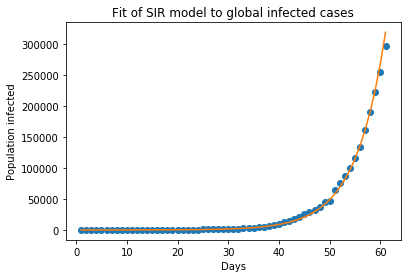

Optimal parameters: beta = 3.0507178764645575  and gamma =  2.8797506898629472


In [23]:
plt.plot(x, y, 'o')
plt.plot(x, fitted)
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

In [24]:
# beta, gamma = popt[0], popt[1]
beta, gamma = beta_hat[0], beta_hat[1]

In [25]:
# The SIR model differential equations.
# def deriv(y, t, N, beta, gamma):
#     S, I, R = y
#     dSdt = -beta * S * I / N
#     dIdt = beta * S * I / N - gamma * I
#     dRdt = gamma * I
#     return dSdt, dIdt, dRdt


In [26]:
y0 = S0, I0, R0
ret = odeint(SIR, y0, X, args=(N, beta, gamma))

S, I, R = ret.T


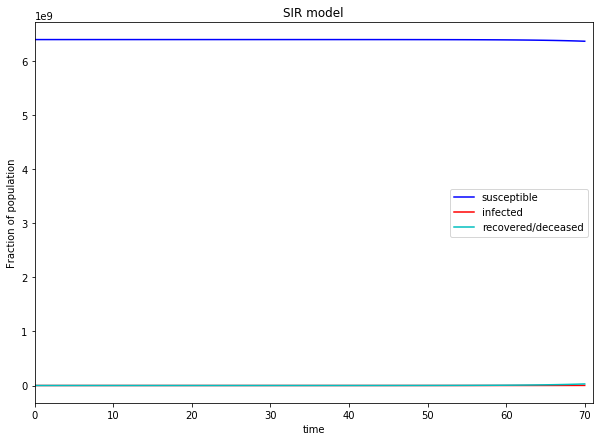

In [27]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b', label='susceptible');
plt.plot(I, 'r', label='infected');
plt.plot(R, 'c', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,len(X))
plt.show()

In [28]:
y0 = S0, I0, R0
ret = odeint(SIR, y0, [i for i in range(150)], args=(N, beta, gamma))

S, I, R = ret.T

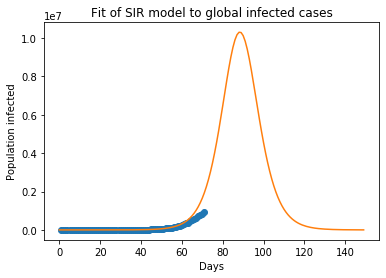

In [29]:
plt.plot(X, Y, 'o')
plt.plot([i for i in range(150)], I)
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

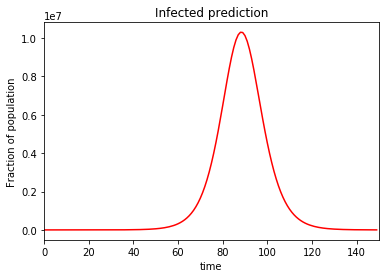

In [31]:
plt.plot(I, 'r', label='infected');
plt.title("Infected prediction")
plt.xlabel("time");
plt.ylabel("Fraction of population");
plt.xlim(0,150)
plt.show()

In [32]:
max(I)

10291786.22876506

In [33]:
max(df['Confirmed'].values)

930725

In [34]:
lim = len(Y)
# mse = mean_squared_error(y, I[:lim])
rmsle = math.sqrt(mean_squared_log_error(Y[index:], I[index:lim]))
print(rmsle)

0.34371886147458214


# Analysing each country individualy

In [35]:
pop = pd.read_csv('datasets\population_by_country_2020.csv')
pop.head()

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1439323776,0.39%,5540090,153,9388211,-348399.0,1.7,38,61%,18.47%
1,India,1380004385,0.99%,13586631,464,2973190,-532687.0,2.2,28,35%,17.70%
2,United States,331002651,0.59%,1937734,36,9147420,954806.0,1.8,38,83%,4.25%
3,Indonesia,273523615,1.07%,2898047,151,1811570,-98955.0,2.3,30,56%,3.51%
4,Pakistan,220892340,2.00%,4327022,287,770880,-233379.0,3.6,23,35%,2.83%


In [36]:
pop = pop[['Country (or dependency)', 'Population (2020)']].rename(columns = {'Country (or dependency)':'Country/Region',
                  'Population (2020)': 'Population'})

In [37]:
pop.head()

,Country/Region,Population
0,China,1439323776
1,India,1380004385
2,United States,331002651
3,Indonesia,273523615
4,Pakistan,220892340


In [38]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [39]:
df_c = df_c.replace('US', 'United States').replace('Korea, South', 'South Korea')

In [40]:
countries = list(set(df_c['Country/Region'].values).intersection(set(pop['Country/Region'].values)))
# len(countries)

In [41]:
country = 'Kenya'

In [42]:
temp = df_c[df_c['Country/Region'] == country].reset_index()
temp = temp[temp['Confirmed'] > 0].fillna(0)
# temp = temp[temp['Confirmed'] > 0].diff().fillna(0)
temp.head()

,index,Country/Region,Lat,Long,Date,Confirmed
50,9139,Kenya,-0.0236,37.9062,2020-03-13,1
51,9320,Kenya,-0.0236,37.9062,2020-03-14,1
52,9501,Kenya,-0.0236,37.9062,2020-03-15,3
53,9682,Kenya,-0.0236,37.9062,2020-03-16,3
54,9863,Kenya,-0.0236,37.9062,2020-03-17,3


In [43]:
N = int(pop[pop['Country/Region'] == country]['Population'])
N

53771296

In [44]:
temp['Day num'] = np.arange(1, len(temp)+1)
temp.tail()

,index,Country/Region,Lat,Long,Date,Confirmed,Day num
66,12035,Kenya,-0.0236,37.9062,2020-03-29,42,17
67,12216,Kenya,-0.0236,37.9062,2020-03-30,50,18
68,12397,Kenya,-0.0236,37.9062,2020-03-31,59,19
69,12578,Kenya,-0.0236,37.9062,2020-04-01,81,20
70,12759,Kenya,-0.0236,37.9062,2020-04-02,110,21


In [45]:
y = temp['Confirmed'].values[:index]
x = temp['Day num'].values[:index]

I0, R0 = y[0], 0
S0 = N - I0 - R0

In [46]:
def SIR(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


In [47]:
def opt_ode(x, beta, gamma):
    return odeint(SIR, (S0, I0, R0), x, args=(N, beta, gamma))[:,1].clip(0)

def err(params, x):
    beta, gamma = params
    ret = odeint(SIR, (S0, I0, R0), x, args=(N, beta, gamma))
    S, I, R = ret.T
    I = I.clip(0)
    error = np.sqrt(mean_squared_log_error(y, I, [1/i for i in x][::-1]))
    return error
    

In [48]:
popt, pcov = optimize.curve_fit(opt_ode, x, y, bounds = [0, np.inf])

result = optimize.minimize(err, popt, args=(x), method='BFGS', options={'maxiter': 500})

beta_hat = result.x
print(popt)
print(result)


[8.47371615 8.23997081]
      fun: 0.21349609242482206
 hess_inv: array([[0.05098158, 0.04498932],
       [0.04498932, 0.03970146]])
      jac: array([ 4.57204878e-05, -2.86102295e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 486
      nit: 5
     njev: 116
   status: 2
  success: False
        x: array([8.47539142, 8.23874052])


In [49]:
# pcov

In [50]:
# fitted = opt_ode(x, *popt)
fitted = opt_ode(x, *beta_hat)

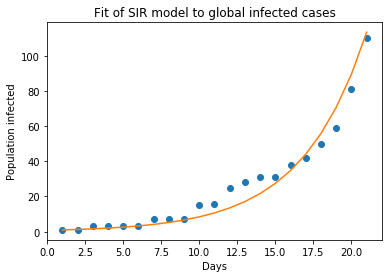

Optimal parameters: beta = 8.473716145686726  and gamma =  8.239970814045266


In [51]:
plt.plot(x, y, 'o')
plt.plot(x, fitted)
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

In [52]:
lim = len(y)
# mse = mean_squared_error(y, I[:lim])
rmsle = (mean_squared_log_error(y, fitted))
print(rmsle)

0.08261885927537742


# SEIR model

In [53]:
# Total population, N without china
N = 6.4 *(10**9)
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0, E0 = 1, 0, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0 - E0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma, sigma = 0.6, 1/10, 0.1

In [54]:
# The SEIR model differential equations.
def SEIR(y, t, N, beta, gamma, sigma):
    S, E, I, R = y
    dSdt = (-beta * S * I) / N
    dEdt = ((beta * S * I) / N) - (sigma * E) 
    dIdt = (sigma * E) - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt


In [55]:
# Initial conditions vector
y0 = S0, E0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(SEIR, y0, [i for i in range(1000)], args=(N, beta, gamma, sigma))

S, E, I, R = ret.T


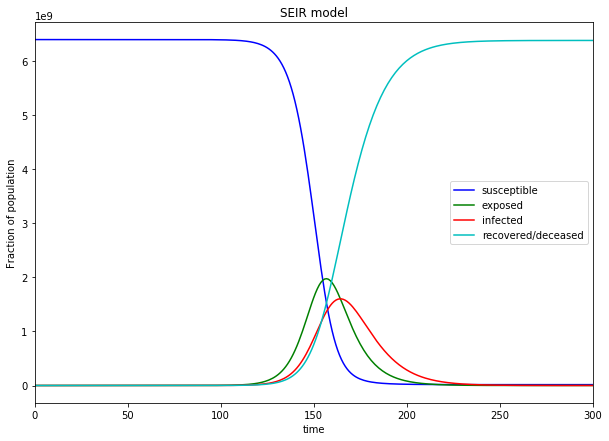

In [56]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b', label='susceptible');
plt.plot(E, 'g', label='exposed');
plt.plot(I, 'r', label='infected');
plt.plot(R, 'c', label='recovered/deceased');
plt.title("SEIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,300)
plt.show()

In [57]:
train = 0.8
index = math.ceil(train * len(df['Confirmed'].values))
index

57

In [58]:
Y = df['Confirmed'].values
X = df['Day num'].values

In [59]:
y = df['Confirmed'].values[:index]
x = df['Day num'].values[:index]

N = int(pop[pop['Country/Region'] != 'China']['Population'].sum())
I0, R0, E0 = y[0], 0, 0
S0 = N - I0 - R0 - E0

In [60]:
def SEIR(y, t, N, beta, gamma, sigma):
    S, E, I, R = y
    dSdt = (-beta * S * I) / N
    dEdt = ((beta * S * I) / N) - (sigma * E) 
    dIdt = (sigma * E) - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt


In [61]:
def opt_ode(x, beta, gamma, sigma):
    return odeint(SEIR, (S0, E0, I0, R0), x, args=(N, beta, gamma, sigma))[:,1].clip(0)

def err(params, x):
    beta, gamma, sigma = params
    ret = odeint(SEIR, (S0, E0, I0, R0), x, args=(N, beta, gamma, sigma))
    S, E, I, R = ret.T
    I = I.clip(0)
    error = np.sqrt(mean_squared_log_error(y, I, [1/i for i in x][::-1]))
    return error
    

In [62]:
# np.array(x)

In [63]:
popt, pcov = optimize.curve_fit(opt_ode, x, y, bounds = [0, np.inf])

result = optimize.minimize(err, popt, args=(x), method='BFGS', options={'maxiter': 500})

beta_hat = result.x
print(result)


      fun: 0.15775005656364569
 hess_inv: array([[ 16.95372234,  17.20247244, -41.48136258],
       [ 17.20247243,  17.45487903, -42.08999596],
       [-41.48136258, -42.08999597, 101.49414555]])
      jac: array([ 0.14077346, -0.15149975, -0.00513238])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1468
      nit: 109
     njev: 289
   status: 2
  success: False
        x: array([-1.11001447, -1.19316949,  2.14744715])


In [64]:
# pcov

In [65]:
# fitted = opt_ode(x, *popt)
# fitted = opt_ode(x, *beta_hat)
y0 = S0, E0, I0, R0
ret = odeint(SEIR, y0, X, args=(N, *beta_hat))
# ret = odeint(deriv, y0, X, args=(N, *popt))

S, E, I, R = ret.T


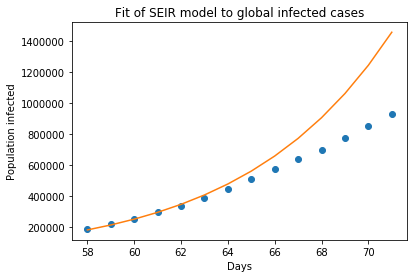

Optimal parameters: beta = 2.040981128035721 , gamma =  0.6373998183457226 , sigma =  0.10216244361535372


In [66]:
plt.plot(X[index:], Y[index:], 'o')
plt.plot(X[index:], I[index:])
plt.title("Fit of SEIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], ", gamma = ", popt[1],", sigma = ", popt[2] )

In [67]:
# beta, gamma, sigma = popt[0], popt[1], popt[2]
beta, gamma, sigma = beta_hat[0], beta_hat[1], beta_hat[2]

In [68]:
# The SIR model differential equations.
def SEIR(y, t, N, beta, gamma, sigma):
    S, E, I, R = y
    dSdt = (-beta * S * I) / N
    dEdt = ((beta * S * I) / N) - (sigma * E) 
    dIdt = (sigma * E) - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt


In [69]:
y0 = S0, E0, I0, R0
ret = odeint(SEIR, y0, [i for i in range(300)], args=(N, beta, gamma, sigma))

S, E, I, R = ret.T


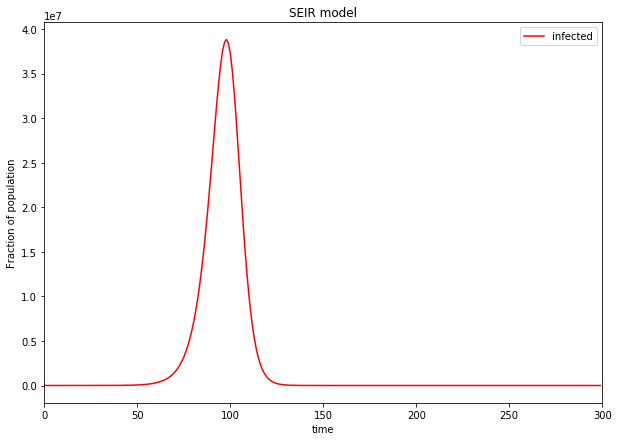

In [70]:
f = plt.figure(figsize=(10,7)) 
# plt.plot(S, 'b.', label='susceptible');
# plt.plot(E, 'g.', label='Exposed');
plt.plot(I, 'r', label='infected');
# plt.plot(R, 'c.', label='recovered/deceased');
plt.title("SEIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,300)
plt.show()

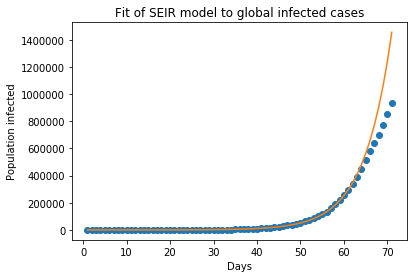

In [72]:
plt.plot(X, Y, 'o')
plt.plot(X, I[:len(Y)])
plt.title("Fit of SEIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

In [73]:
lim = len(y)
mse = mean_squared_error(y, I[:lim])
rmsle = (mean_squared_log_error(Y, I[:len(Y)]))
print(rmsle)

0.0624766673380778


In [74]:
# [1/i for i in x][::-1]

In [75]:
max(I)

38811539.09071616

# Analysing each country individualy

In [76]:
pop = pd.read_csv('datasets\population_by_country_2020.csv')
pop.head()

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1439323776,0.39%,5540090,153,9388211,-348399.0,1.7,38,61%,18.47%
1,India,1380004385,0.99%,13586631,464,2973190,-532687.0,2.2,28,35%,17.70%
2,United States,331002651,0.59%,1937734,36,9147420,954806.0,1.8,38,83%,4.25%
3,Indonesia,273523615,1.07%,2898047,151,1811570,-98955.0,2.3,30,56%,3.51%
4,Pakistan,220892340,2.00%,4327022,287,770880,-233379.0,3.6,23,35%,2.83%


In [77]:
pop = pop[['Country (or dependency)', 'Population (2020)']].rename(columns = {'Country (or dependency)':'Country/Region',
                  'Population (2020)': 'Population'})

In [78]:
pop.head()

,Country/Region,Population
0,China,1439323776
1,India,1380004385
2,United States,331002651
3,Indonesia,273523615
4,Pakistan,220892340


In [79]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [80]:
df_c = df_c.replace('US', 'United States').replace('Korea, South', 'South Korea')

In [81]:
countries = list(set(df_c['Country/Region'].values).intersection(set(pop['Country/Region'].values)))
# len(countries)

In [82]:
country ='Portugal'

In [83]:
temp = df_c[df_c['Country/Region'] == country]
temp = temp[temp['Confirmed'] > 0].fillna(0)
# temp = temp[temp['Confirmed'] > 0].diff().fillna(0)
temp.head()

,Country/Region,Lat,Long,Date,Confirmed
7194,Portugal,39.3999,-8.2245,2020-03-02,2
7375,Portugal,39.3999,-8.2245,2020-03-03,2
7556,Portugal,39.3999,-8.2245,2020-03-04,5
7737,Portugal,39.3999,-8.2245,2020-03-05,8
7918,Portugal,39.3999,-8.2245,2020-03-06,13


In [84]:
N = int(pop[pop['Country/Region'] == country]['Population'])
N

10196709

In [85]:
temp['Day num'] = np.arange(1, len(temp)+1)
temp.tail()

,Country/Region,Lat,Long,Date,Confirmed,Day num
12081,Portugal,39.3999,-8.2245,2020-03-29,5962,28
12262,Portugal,39.3999,-8.2245,2020-03-30,6408,29
12443,Portugal,39.3999,-8.2245,2020-03-31,7443,30
12624,Portugal,39.3999,-8.2245,2020-04-01,8251,31
12805,Portugal,39.3999,-8.2245,2020-04-02,9034,32


In [86]:
Y = temp['Confirmed'].values
X = temp['Day num'].values

In [87]:
y = temp['Confirmed'].values
x = temp['Day num'].values

# N = int(pop[pop['Country/Region'] != 'China']['Population'].sum())
I0, R0, E0 = y[0], 0, 0
S0 = N - I0 - R0 - E0

In [88]:
def SEIR(y, t, N, beta, gamma, sigma):
    S, E, I, R = y
    dSdt = (-beta * S * I) / N
    dEdt = ((beta * S * I) / N) - (sigma * E) 
    dIdt = (sigma * E) - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt


In [89]:
def opt_ode(x, beta, gamma, sigma):
    return odeint(SEIR, (S0, E0, I0, R0), x, args=(N, beta, gamma, sigma))[:,1].clip(0)

def err(params, x):
    beta, gamma, sigma = params
    ret = odeint(SEIR, (S0, E0, I0, R0), x, args=(N, beta, gamma, sigma))
    S, E, I, R = ret.T
    I = I.clip(0)
    error = np.sqrt(mean_squared_log_error(y, I, [1/i for i in x][::-1]))
    return error
    

In [90]:
# np.array(x)

In [91]:
popt, pcov = optimize.curve_fit(opt_ode, x, y, bounds = [0, np.inf])

result = optimize.minimize(err, popt, args=(x), method='BFGS', options={'maxiter': 500})

beta_hat = result.x
print(result)


      fun: 0.08834459590788718
 hess_inv: array([[1.34803568e-02, 6.13586205e-03, 1.61871575e-04],
       [6.13586205e-03, 2.79325056e-03, 7.36889021e-05],
       [1.61871575e-04, 7.36889021e-05, 1.94423502e-06]])
      jac: array([-1.39259789e-02, -7.11670510e-01,  2.82704178e+01])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1026
      nit: 18
     njev: 201
   status: 2
  success: False
        x: array([ 1.15418622e+01, -5.42451764e-01, -6.83979028e-03])


In [92]:
# pcov

In [93]:
# fitted = opt_ode(x, *popt)
# fitted = opt_ode(x, *beta_hat)
y0 = S0, E0, I0, R0
ret = odeint(SEIR, y0, X, args=(N, *beta_hat))
# ret = odeint(deriv, y0, X, args=(N, *popt))

S, E, I, R = ret.T


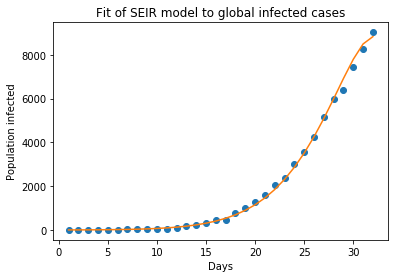

Optimal parameters: beta = 12.626260942096376 , gamma =  1.4754663567385588e-11 , sigma =  0.0019189219437809346


In [94]:
plt.plot(x, y, 'o')
plt.plot(x, I)
plt.title("Fit of SEIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], ", gamma = ", popt[1],", sigma = ", popt[2] )

In [95]:
lim = len(y)
mse = mean_squared_error(y, I[:lim])
rmsle = (mean_squared_log_error(Y, I))
print(rmsle)

0.01966467687808669


# SIQR model

In [96]:
# Total population, N without china
N = 6.4 *(10**9)
I0, R0, Q0 = 10, 0, 0
S0 = N - I0 - R0 - Q0
beta, gamma, alpha, theta = 2.0, 1/10, 1.0, 0.3

In [97]:
# The SIQR model differential equations.

def SIQR(y, t, N, alpha, beta, gamma, theta):
    S, I, Q, R = y
    dSdt = (-beta * S * I) / N
    dIdt = ((beta * S * I) / N) - ((theta + alpha) * I)
    dQdt = (theta * I) - (gamma * Q) 
    dRdt = (alpha * I) + (gamma * Q)
    return dSdt, dIdt, dQdt, dRdt


In [98]:
# Initial conditions vector
y0 = S0, I0, Q0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(SIQR, y0, [i for i in range(100)], args=(N, alpha, beta, gamma, theta))

S, I, Q, R = ret.T


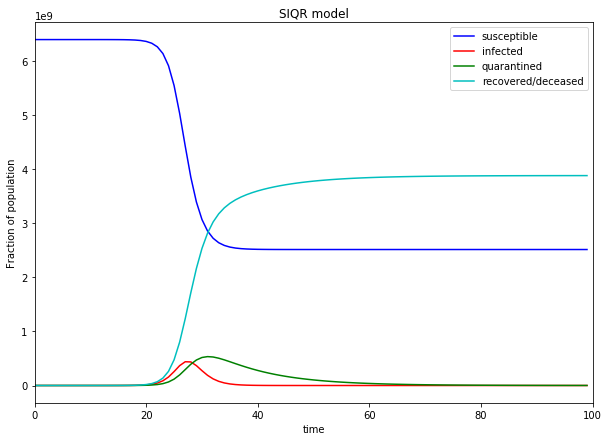

In [99]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b', label='susceptible');
plt.plot(I, 'r', label='infected');
plt.plot(Q, 'g', label='quarantined');
plt.plot(R, 'c', label='recovered/deceased');
plt.title("SIQR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,100)
plt.show()

In [100]:
train = 0.8
index = math.ceil(train * len(df['Confirmed'].values))
index

57

In [101]:
Y = df['Confirmed'].values
X = df['Day num'].values

In [102]:
y = df['Confirmed'].values[:index]
x = df['Day num'].values[:index]

N = int(pop[pop['Country/Region'] != 'China']['Population'].sum())
I0, R0, Q0 = y[0], 0, 0
S0 = N - I0 - R0 - Q0

In [103]:
# S0

In [104]:
def SIQR(y, t, N, alpha, beta, gamma, theta):
    S, I, Q, R = y
    dSdt = (-beta * S * I) / N
    dIdt = ((beta * S * I) / N) - ((theta + alpha) * I)
    dQdt = (theta * I) - (gamma * Q) 
    dRdt = (alpha * I) + (gamma * Q)
    return dSdt, dIdt, dQdt, dRdt

In [105]:
def opt_ode(x, alpha, beta, gamma, theta):
    return odeint(SIQR, (S0, I0, Q0, R0), x, args=(N, alpha, beta, gamma, theta))[:,1].clip(0)

def err(params, x):
    alpha, beta, gamma, theta = params
    ret = odeint(SIQR, (S0, I0, Q0, R0), x, args=(N, alpha, beta, gamma, theta))
    S, I, Q, R = ret.T
    I = I.clip(0)
    error = np.sqrt(mean_squared_log_error(y, I, [1/i for i in x][::-1]))
    return error
    

In [106]:
# np.array(x)

In [107]:
popt, pcov = optimize.curve_fit(opt_ode, x, y, bounds = [0, np.inf])

result = optimize.minimize(err, popt, args=(x), method='BFGS', options={'maxiter': 500})

beta_hat = result.x
print(beta_hat)


[1.06309694 2.74889176 2.41706944 1.51350756]


In [108]:
# pcov

In [109]:
# fitted = opt_ode(x, *popt)
# fitted = opt_ode(x, *beta_hat)
y0 = S0, I0, Q0, R0
ret = odeint(SIQR, y0, X, args=(N, *beta_hat))
# ret = odeint(deriv, y0, X, args=(N, *popt))

S, I, Q, R = ret.T


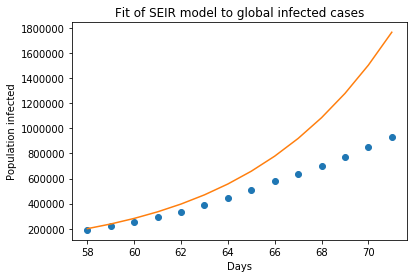

Optimal parameters: beta = 1.0632538254714752 , gamma =  2.74873265655217 , sigma =  2.417067785068633


In [110]:
plt.plot(X[index:], Y[index:], 'o')
plt.plot(X[index:], I[index:])
plt.title("Fit of SEIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], ", gamma = ", popt[1],", sigma = ", popt[2] )

In [111]:
# beta, gamma, sigma = popt[0], popt[1], popt[2]
alpha, beta, gamma, theta = beta_hat[0], beta_hat[1], beta_hat[2], beta_hat[3]

In [112]:
def SIQR(y, t, N, alpha, beta, gamma, theta):
    S, I, Q, R = y
    dSdt = (-beta * S * I) / N
    dIdt = ((beta * S * I) / N) - ((theta + alpha) * I)
    dQdt = (theta * I) - (gamma * Q) 
    dRdt = (alpha * I) + (gamma * Q)
    return dSdt, dIdt, dQdt, dRdt


In [113]:
y0 = S0, I0, Q0, R0
ret = odeint(SIQR, y0, [i for i in range(300)], args=(N, alpha, beta, gamma, theta))

S, I, Q, R = ret.T


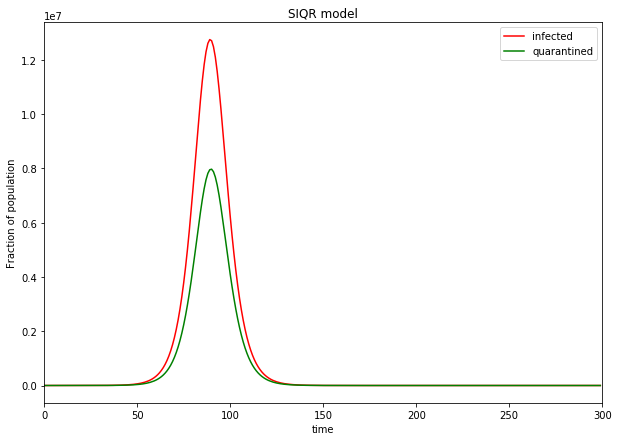

In [114]:
f = plt.figure(figsize=(10,7)) 
# plt.plot(S, 'b', label='susceptible');
plt.plot(I, 'r', label='infected');
plt.plot(Q, 'g', label='quarantined');
# plt.plot(R, 'c', label='recovered/deceased');
plt.title("SIQR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,300)
plt.show()

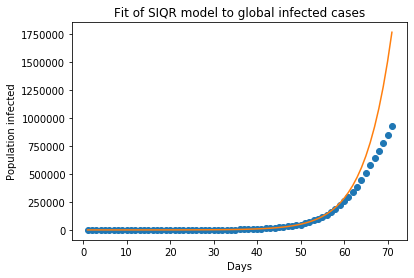

In [115]:
plt.plot(X, Y, 'o')
plt.plot(X, I[:len(Y)])
plt.title("Fit of SIQR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

In [116]:
lim = len(y)
mse = mean_squared_error(y, I[:lim])
rmsle = (mean_squared_log_error(Y, I[:len(Y)]))
print(rmsle)

0.18027203111341739


# SEIR with social distancing

In [117]:
# Total population, N without china
N = 6.4 *(10**9)
I0, R0, E0 = 1, 0, 0
S0 = N - I0 - R0 - E0
beta, gamma, sigma, alpha = 1.75, 0.5, 0.2, 0.5

In [118]:
# The SIR model differential equations.
def SEIRsd(y, t, N, beta, gamma, sigma, alpha):
    S, E, I, R = y
    dSdt = (-alpha * beta * S * I) / N
    dEdt = ((alpha * beta * S * I) / N) - (sigma * E) 
    dIdt = (sigma * E) - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt


In [119]:
# Initial conditions vector
y0 = S0, E0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(SEIRsd, y0, [i for i in range(1000)], args=(N, beta, gamma, sigma, alpha))

S, E, I, R = ret.T


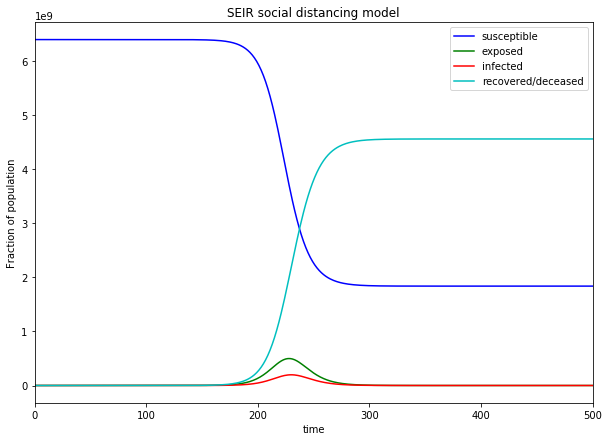

In [120]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b', label='susceptible');
plt.plot(E, 'g', label='exposed');
plt.plot(I, 'r', label='infected');
plt.plot(R, 'c', label='recovered/deceased');
plt.title("SEIR social distancing model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,500)
plt.show()

## Comparison with and without social distancing

In [121]:
def SEIR(y, t, N, beta, gamma, sigma):
    S, E, I, R = y
    dSdt = (-beta * S * I) / N
    dEdt = ((beta * S * I) / N) - (sigma * E) 
    dIdt = (sigma * E) - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt


In [122]:
y0 = S0, E0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret1 = odeint(SEIR, y0, [i for i in range(1000)], args=(N, beta, gamma, sigma))

S1, E1, I1, R1 = ret1.T

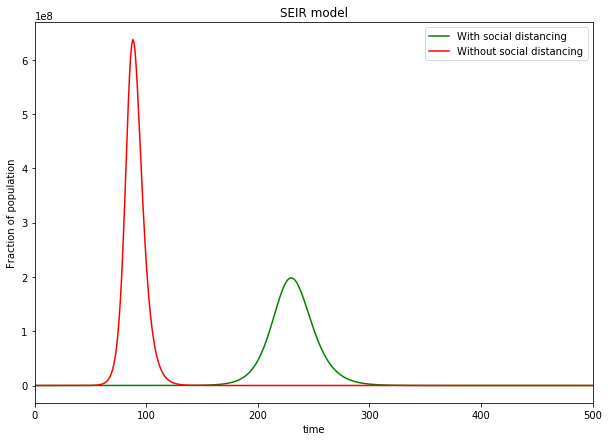

In [123]:
f = plt.figure(figsize=(10,7)) 
# plt.plot(S, 'b', label='susceptible');
plt.plot(I, 'g', label='With social distancing');
plt.plot(I1, 'r', label='Without social distancing');
# plt.plot(R, 'c', label='recovered/deceased');
plt.title("SEIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,500)
plt.show()

In [124]:
train = 0.8
index = math.ceil(train * len(df['Confirmed'].values))
index

57

In [125]:
Y = df['Confirmed'].values
X = df['Day num'].values

In [126]:
y = df['Confirmed'].values
x = df['Day num'].values

N = int(pop[pop['Country/Region'] != 'China']['Population'].sum())
I0, R0, E0 = y[0], 0, 0
S0 = N - I0 - R0 - E0

In [127]:
# The SIR model differential equations.
def SEIRsd(y, t, N, beta, gamma, sigma, alpha):
    S, E, I, R = y
    dSdt = (-alpha * beta * S * I) / N
    dEdt = ((alpha * beta * S * I) / N) - (sigma * E) 
    dIdt = (sigma * E) - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

In [128]:
def opt_ode(x, beta, gamma, sigma, alpha):
    if alpha > 1:
        alpha = 1
    elif alpha < 0:
        alpha = 0
    return odeint(SEIRsd, (S0, E0, I0, R0), x, args=(N, beta, gamma, sigma, alpha))[:,1].clip(0)

def err(params, x):
    beta, gamma, sigma, alpha = params
    if alpha > 1:
        alpha = 1
    elif alpha < 0:
        alpha = 0
    ret = odeint(SEIRsd, (S0, E0, I0, R0), x, args=(N, beta, gamma, sigma, alpha))
    S, E, I, R = ret.T
    I = I.clip(0)
    error = np.sqrt(mean_squared_log_error(y, I, [1/i for i in x][::-1]))
    return error
    

In [129]:
# np.array(x)

In [130]:
popt, pcov = optimize.curve_fit(opt_ode, x, y, bounds = [0, np.inf])

result = optimize.minimize(err, popt, args=(x), method='BFGS', options={'maxiter': 1000})

beta_hat = result.x
print(result)


      fun: 0.1958001467951895
 hess_inv: array([[1.05818504e-01, 3.01126394e-02, 1.15753052e-03, 0.00000000e+00],
       [3.01126394e-02, 1.15418255e-02, 4.39217534e-04, 0.00000000e+00],
       [1.15753052e-03, 4.39217534e-04, 1.67335913e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
      jac: array([-7.09544867e-04, -3.80869210e-02,  1.53939763e+00,  0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 552
      nit: 17
     njev: 90
   status: 2
  success: False
        x: array([ 4.60828262e+00, -2.57186287e-01, -3.48090349e-03,  1.00000000e+00])


In [131]:
# pcov

In [132]:
# fitted = opt_ode(x, *popt)
# fitted = opt_ode(x, *beta_hat)
y0 = S0, E0, I0, R0
ret = odeint(SEIRsd, y0, X, args=(N, *beta_hat))
# ret = odeint(deriv, y0, X, args=(N, *popt))

S, E, I, R = ret.T


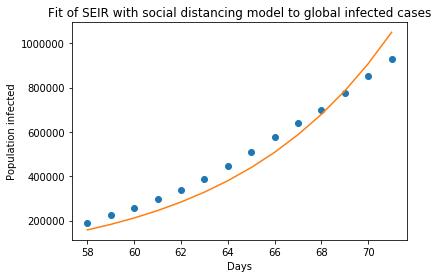

Optimal parameters: beta = 5.889527015517568 , gamma =  0.11900040514906705 , sigma =  0.005300293085334524


In [133]:
plt.plot(X[index:], Y[index:], 'o')
plt.plot(X[index:], I[index:])
plt.title("Fit of SEIR with social distancing model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], ", gamma = ", popt[1],", sigma = ", popt[2] )

In [134]:
# beta, gamma, sigma = popt[0], popt[1], popt[2]
beta, gamma, sigma, alpha = beta_hat[0], beta_hat[1], beta_hat[2], beta_hat[3]

In [135]:
def SEIRsd(y, t, N, beta, gamma, sigma, alpha):
    S, E, I, R = y
    dSdt = (-alpha * beta * S * I) / N
    dEdt = ((alpha * beta * S * I) / N) - (sigma * E) 
    dIdt = (sigma * E) - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

In [138]:
y0 = S0, E0, I0, R0
ret = odeint(SEIRsd, y0, [i for i in range(500)], args=(N, beta, gamma, sigma, alpha))

S, E, I, R = ret.T


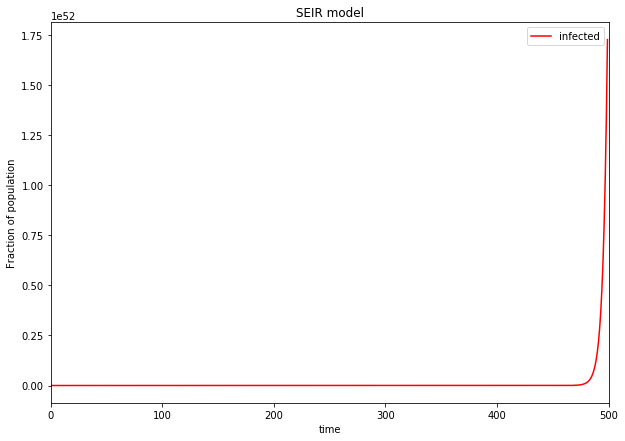

In [139]:
f = plt.figure(figsize=(10,7)) 
# plt.plot(S, 'b.', label='susceptible');
# plt.plot(E, 'g.', label='Exposed');
plt.plot(I, 'r', label='infected');
# plt.plot(R, 'c.', label='recovered/deceased');
plt.title("SEIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,500)
plt.show()

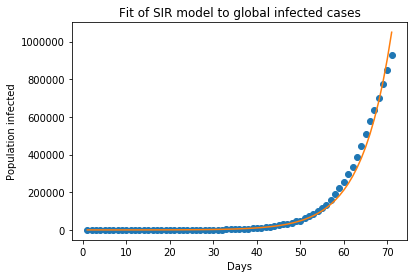

In [140]:
plt.plot(X, Y, 'o')
plt.plot(X, I[:len(Y)])
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

In [141]:
lim = len(y)
mse = mean_squared_error(y, I[:lim])
rmsle = (mean_squared_log_error(Y, I[:len(Y)]))
print(rmsle)

0.10205534672778072
